# PINN for Poisson equation
# With RAR-D adaptive sampling with fixed domain sampling interval
$$
\nabla^2 u = f
$$



In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Check device (use MPS if on silicon Mac or CUDA if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# print device
print(f"Using device: {device}")


Using device: mps


In [10]:
# Define the analytical solution
def analytical_solution(x, y):
    return torch.sin(4 * np.pi * (x + y)) + torch.cos(4 * np.pi * x * y)


In [11]:
# Define the model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 1)
        )

    def forward(self, xy):
        # xy represents the coordinates (x, y) concatenated
        u = self.net(xy)
        return u

def laplacian(u, xy):
    # Compute gradients du/dx and du/dy
    grads = torch.autograd.grad(outputs=u, inputs=xy, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    
    # Compute second derivatives 
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True, retain_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True, retain_graph=True)[0][:, 1]
    
    laplacian = u_xx + u_yy
    return laplacian 

def loss_pinn(model, xy, x_boundary, u_boundary, f):
    xy = xy.clone().detach().requires_grad_(True)
    x_boundary = x_boundary.clone().detach().requires_grad_(True)
    f = f.clone().detach()
    #predictions
    u = model(xy)
    #compute laplacian
    laplacian_u = laplacian(u, xy)
    physical_loss = torch.mean((laplacian_u - f)**2)
    # boundary condition loss
    u_boundary_pred = model(x_boundary)
    boundary_loss = torch.mean((u_boundary_pred - u_boundary)**2)
    return physical_loss +  15 * boundary_loss


def compute_residuals(model, points):
    """Compute residuals at given points"""
    points = points.clone().detach().requires_grad_(True)
    u = model(points)
    laplacian_u = laplacian(u, points)
    u_analytical = analytical_solution(points[:, 0], points[:, 1])
    f = laplacian(u_analytical, points)
    residuals = torch.abs(laplacian_u - f)
    return residuals.detach()


def compute_pdf(residuals, k=1, c=1):
    """
    Compute the probability density function (PDF) based on residuals using RAD equation (2).
    
    Parameters:
        residuals: Tensor of residual values (epsilon(x)).
        k: Exponent for residual weighting (default=1).
        c: Minimum probability mass constant (default=0.01).
    
    Returns:
        pdf: Normalized probability density function values.
    """
    # Raise residuals to the power of k
    weighted_residuals = residuals ** k
    
    # Compute the expectation of weighted residuals
    expectation = torch.mean(weighted_residuals)
    
    # Compute the PDF with the added constant c
    pdf = weighted_residuals / expectation + c
    return pdf


def adaptive_sampling_RAR_D(model,training_points, n_points, k=2, c=0):
    """Perform adaptive sampling based on residuals"""
    # Generate candidate points
    n_dense = 50000
    candidates = torch.rand((n_dense, 2), device=device)
    
    # Compute residuals for all candidates
    residuals = compute_residuals(model, candidates)
    
    pdf = compute_pdf(residuals, k, c)
    probabilities = pdf / torch.sum(pdf)
    indices = torch.multinomial(probabilities.flatten(), n_points, replacement=False)
    sampled_points = candidates[indices]
    training_points = torch.cat([training_points, sampled_points], dim=0)
    return training_points


In [12]:
# Problem setup
# Interior points (uniformly sampled within [0 , 1] x [0, 1])
x_interior = torch.rand((250, 2), device=device)  # Random points in [0, 1] x [0, 1]
# f is the source term i.e. laplactian of u
x_interior = x_interior.requires_grad_(True)
u_analytical = analytical_solution(x_interior[:, 0], x_interior[:, 1])
f = laplacian(u_analytical, x_interior)
x_interior.requires_grad_(False) 

# Boundary points
x_boundary_x = torch.linspace(0, 1, 100, device=device).unsqueeze(1)
x_boundary = torch.cat([
    torch.cat([x_boundary_x, torch.zeros_like(x_boundary_x)], dim=1),
    torch.cat([x_boundary_x, torch.ones_like(x_boundary_x)], dim=1),
    torch.cat([torch.zeros_like(x_boundary_x), x_boundary_x], dim=1),
    torch.cat([torch.ones_like(x_boundary_x), x_boundary_x], dim=1),
], dim=0)

# Boundary condition values using the analytical solution
u_boundary = analytical_solution(x_boundary[:, 0], x_boundary[:, 1]).unsqueeze(1).to(device)




In [13]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

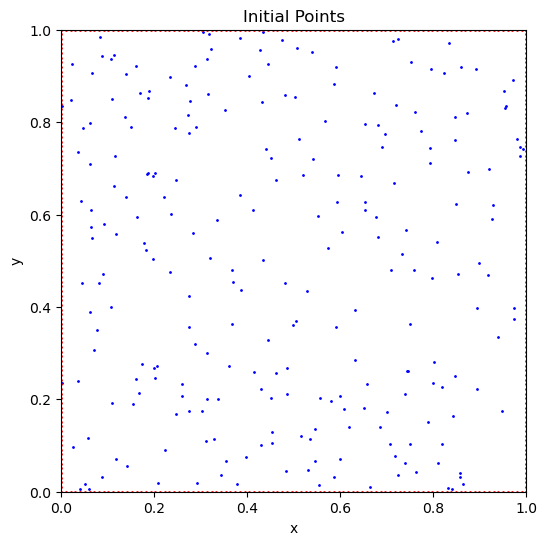

Epoch 1: Loss = 46935.20703125, LR = 0.001
Epoch 51: Loss = 30537.634765625, LR = 0.001
Epoch 101: Loss = 23341.025390625, LR = 0.001


KeyboardInterrupt: 

In [14]:
# ... existing code ...

# Training
num_epochs = 10000 
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Points to add
n_interior_points = 50 
loss_history = []
resample_threshold = 0.01  # 1% change
check_interval = 100  # Check every 5 epochs


# Plot initial points
plt.figure(figsize=(6, 6))
plt.scatter(x_interior[:, 0].cpu().numpy(), x_interior[:, 1].cpu().numpy(), s=1, c='blue', label='Interior Points')
plt.scatter(x_boundary[:, 0].cpu().numpy(), x_boundary[:, 1].cpu().numpy(), s=1, c='red', label='Boundary Points')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Initial Points")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_pinn(model, x_interior, x_boundary, u_boundary, f)
    loss.backward()
    optimizer.step()

    # Store loss history
    loss_history.append(loss.item())


    # Perform resampling at fixed intervals
    if epoch >= check_interval:
        recent_losses = loss_history[-check_interval:]
        relative_change = abs(recent_losses[-1] - recent_losses[0]) / recent_losses[0]
        
        if relative_change < resample_threshold:
            # Resample interior points
            x_interior = adaptive_sampling_RAR_D(model, x_interior, n_interior_points)
            x_interior = x_interior.requires_grad_(True)
            
            # Update source term f
            u_analytical = analytical_solution(x_interior[:, 0], x_interior[:, 1])
            f = laplacian(u_analytical, x_interior)
            x_interior.requires_grad_(False)
            
            # Plot resampled points (optional)
            clear_output(wait=True)
            plt.scatter(x_interior[:, 0].cpu().numpy(), x_interior[:, 1].cpu().numpy(), s=1, c='blue', label='Interior Points')
            plt.scatter(x_boundary[:, 0].cpu().numpy(), x_boundary[:, 1].cpu().numpy(), s=1, c='red', label='Boundary Points')
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.title(f"Sampled Points at Epoch {epoch + 1}")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.show()
        
    # Print progress
    if epoch % 50 == 0:
        print(f"Epoch {epoch + 1}: Loss = {loss.item()}, LR = {optimizer.param_groups[0]['lr']}")

    # check if number of training points is too large
    if len(x_interior) > 10000:
        print("Number of training points is too large, stopping training")
        break



/opt/homebrew/Caskroom/miniconda/base/envs/deep/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1724788636145/work/aten/src/ATen/native/TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


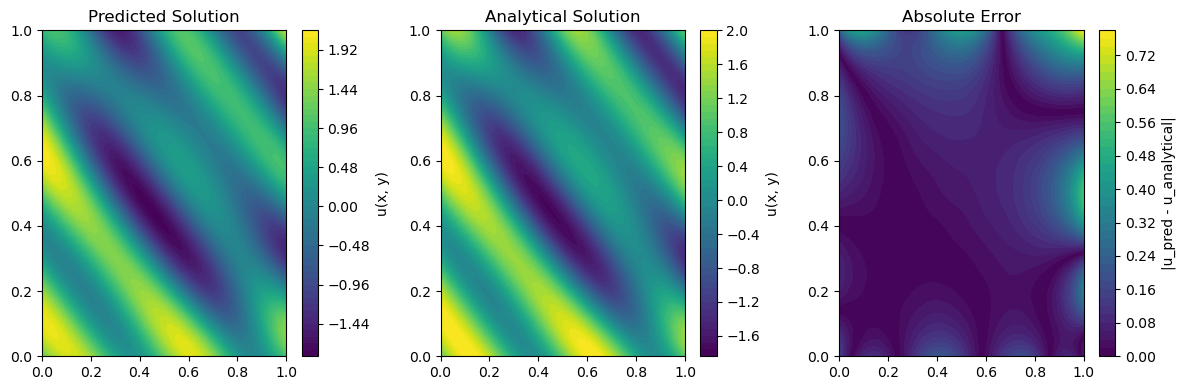

In [8]:
# Plotting: 
grid_x, grid_y = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 1, 100))
grid_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=-1).to(device)

# Predict solution on the grid
with torch.no_grad():
    u_pred = model(grid_points).reshape(100, 100).cpu().numpy()

# Calculate analytical solution on the grid
x_vals = grid_x.cpu().numpy()
y_vals = grid_y.cpu().numpy()
u_analytical = analytical_solution(grid_x, grid_y).cpu().numpy()

# Plot the predicted solution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.contourf(x_vals, y_vals, u_pred, levels=50)
plt.colorbar(label="u(x, y)")
plt.title("Predicted Solution")

# Plot the analytical solution
plt.subplot(1, 3, 2)
plt.contourf(x_vals, y_vals, u_analytical, levels=50)
plt.colorbar(label="u(x, y)")
plt.title("Analytical Solution")

# Plot the difference
plt.subplot(1, 3, 3)
plt.contourf(x_vals, y_vals, np.abs(u_pred - u_analytical), levels=50)
plt.colorbar(label="|u_pred - u_analytical|")
plt.title("Absolute Error")

plt.tight_layout()
plt.show()

In [9]:
# evaluate output in (0.5, 0.5)
model(torch.tensor([0.4, 0.2], device=device))

tensor([1.5149], device='mps:0', grad_fn=<LinearBackward0>)